# Nike Shoes Dataset with TensorFlow Decision 

This code was based off a notebook for the Spaceship Titanic competition: [Spaceship Titanic with TFDF
](https://www.kaggle.com/code/gusthema/spaceship-titanic-with-tfdf)

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the library

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.4.0


# Load the Dataset

In [5]:
# Load a dataset into a Pandas Dataframe
# dataset_df = pd.read_csv('./shoes.csv')
dataset_df = pd.read_csv("/kaggle/input/shoepricedata/shoes.csv")
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (873, 16)


In [6]:
# Display the first 5 examples
dataset_df.head(5)

,Pid,Shoe name,isNew,Gender,category,isBestSeller,isMemberExclusive,isSustainable,inStock,numColors,Color 1,Color 2,Color 3,Color 4,Price,Expensive
0,1012596804,Air VaporMax Plus,True,Women,Shoes,False,False,False,True,3,Pink Blast,Black,Clear Jade,NaN,210,True
1,1010124075,Air VaporMax Plus,False,Women,Shoes,False,False,False,True,4,Hyper Pink,White,Pink Blast,Hyper Pink,210,True
2,1008060923,Air VaporMax Plus,False,Women,Shoes,False,False,False,True,4,Fuchsia Dream,Vivid Orange,Baltic Blue,Bright Crimson,210,True
3,1011847829,Air VaporMax Plus,False,Women,Shoes,False,False,False,True,4,Pink Spell,Spring Green,Racer Blue,Citron Pulse,210,True
4,13125335,Air VaporMax Plus,False,Women,Shoes,False,False,False,True,3,Black,Anthracite,Black,NaN,210,True


These are the feature columns.

# Let us quickly do a basic exploration of the dataset

In [7]:
dataset_df.describe()

,Pid,numColors,Price
count,8.730000e+02,873.000000,873.000000
mean,6.890149e+08,3.537228,125.698740
std,4.656077e+08,0.654063,45.464269
min,1.010745e+07,1.000000,25.000000
25%,1.418826e+07,3.000000,90.000000
50%,1.009763e+09,4.000000,125.000000
75%,1.012255e+09,4.000000,160.000000
max,1.014425e+09,4.000000,305.000000


In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Pid                873 non-null    int64 
 1   Shoe name          873 non-null    object
 2   isNew              873 non-null    bool  
 3   Gender             873 non-null    object
 4   category           873 non-null    object
 5   isBestSeller       873 non-null    bool  
 6   isMemberExclusive  873 non-null    bool  
 7   isSustainable      873 non-null    bool  
 8   inStock            873 non-null    bool  
 9   numColors          873 non-null    int64 
 10  Color 1            873 non-null    object
 11  Color 2            869 non-null    object
 12  Color 3            803 non-null    object
 13  Color 4            543 non-null    object
 14  Price              873 non-null    int64 
 15  Expensive          873 non-null    bool  
dtypes: bool(6), int64(3), object(7)
memory usage

# Bar chart for label column: isNew



<Axes: >

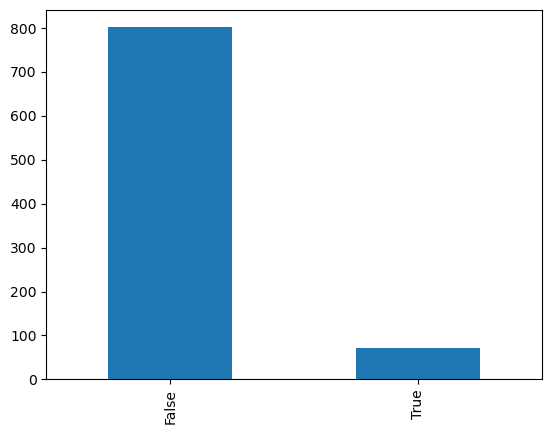

In [9]:
plot_df = dataset_df.isNew.value_counts()
plot_df.plot(kind="bar")

# Numerical data distribution

Let us plot all the numerical columns and their value counts:

# Prepare the dataset

We will drop the `Price` column because it makes things too easy and we want to NOT use the price to determine if a shoe is expensive.

In [10]:
dataset_df = dataset_df.drop('Price', axis=1)
dataset_df = dataset_df.drop('Pid', axis=1)
dataset_df.head(5)

,Shoe name,isNew,Gender,category,isBestSeller,isMemberExclusive,isSustainable,inStock,numColors,Color 1,Color 2,Color 3,Color 4,Expensive
0,Air VaporMax Plus,True,Women,Shoes,False,False,False,True,3,Pink Blast,Black,Clear Jade,NaN,True
1,Air VaporMax Plus,False,Women,Shoes,False,False,False,True,4,Hyper Pink,White,Pink Blast,Hyper Pink,True
2,Air VaporMax Plus,False,Women,Shoes,False,False,False,True,4,Fuchsia Dream,Vivid Orange,Baltic Blue,Bright Crimson,True
3,Air VaporMax Plus,False,Women,Shoes,False,False,False,True,4,Pink Spell,Spring Green,Racer Blue,Citron Pulse,True
4,Air VaporMax Plus,False,Women,Shoes,False,False,False,True,3,Black,Anthracite,Black,NaN,True


We will check for the missing values using the following code:

In [12]:
dataset_df.isnull().sum().sort_values(ascending=False)

Color 4              330
Color 3               70
Color 2                4
Shoe name              0
isNew                  0
Gender                 0
category               0
isBestSeller           0
isMemberExclusive      0
isSustainable          0
inStock                0
numColors              0
Color 1                0
Expensive              0
dtype: int64

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required.

But this datatset also has boolean fields with missing values. TF-DF doesn't support boolean fields yet. So we need to convert those fields into int. To account for the missing values in the boolean fields, we will replace them with zero.

In this notebook, we will replace null value entries with zero for numerical columns as well and only let TF-DF handle the missing values in categorical columns.

Note: You can choose to let TF-DF handle missing values in numerical columns if need be.

Since, TF-DF cannot handle boolean columns, we will have to adjust the labels in the columns to convert them into the integer format that TF-DF expects.

In [14]:
label = "Expensive"

We will also convert the boolean fields to int.

In [15]:
dataset_df['isNew'] = dataset_df['isNew'].astype(int)
dataset_df['isBestSeller'] = dataset_df['isBestSeller'].astype(int)
dataset_df['isMemberExclusive'] = dataset_df['isMemberExclusive'].astype(int)
dataset_df['inStock'] = dataset_df['inStock'].astype(int)
dataset_df['isSustainable'] = dataset_df['isSustainable'].astype(int)
dataset_df['Expensive'] = dataset_df['Expensive'].astype(int)

Let us display the first 5 examples from the prepared dataset.

In [16]:
dataset_df.head(5)

,Shoe name,isNew,Gender,category,isBestSeller,isMemberExclusive,isSustainable,inStock,numColors,Color 1,Color 2,Color 3,Color 4,Expensive
0,Air VaporMax Plus,1,Women,Shoes,0,0,0,1,3,Pink Blast,Black,Clear Jade,NaN,1
1,Air VaporMax Plus,0,Women,Shoes,0,0,0,1,4,Hyper Pink,White,Pink Blast,Hyper Pink,1
2,Air VaporMax Plus,0,Women,Shoes,0,0,0,1,4,Fuchsia Dream,Vivid Orange,Baltic Blue,Bright Crimson,1
3,Air VaporMax Plus,0,Women,Shoes,0,0,0,1,4,Pink Spell,Spring Green,Racer Blue,Citron Pulse,1
4,Air VaporMax Plus,0,Women,Shoes,0,0,0,1,3,Black,Anthracite,Black,NaN,1


Now let us split the dataset into training and testing datasets:

In [17]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

694 examples in training, 179 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

In [18]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [19]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# Configure the model

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

In [148]:
tuner = tfdf.tuner.RandomSearch(num_trials=20)

In [149]:
# tuner.choice("min_examples", [2, 5, 7, 10])
# tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

# Some hyper-parameters are only valid for specific values of other
# hyper-parameters. For example, the "max_depth" parameter is mostly useful when
# "growing_strategy=LOCAL" while "max_num_nodes" is better suited when
# "growing_strategy=BEST_FIRST_GLOBAL".

# local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
# local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

# # merge=True indicates that the parameter (here "growing_strategy") is already
# # defined, and that new values are added to it.
# global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
# global_search_space.choice("max_num_nodes", [6, 12, 32, 64])

# tuner.choice("use_hessian_gain", [True, False])
# tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
# tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])


# Create a Forest

In [150]:
model = tfdf.keras.RandomForestModel(
    num_trees=45,
    hyperparameter_template="benchmark_rank1",
    # growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=10,
    # split_axis="SPARSE_OBLIQUE",
#     categorical_algorithm="RANDOM",
#     winner_take_all=True,
    tuner=tuner
)

model.compile(metrics=[
    "accuracy",
#     "mae","mse"
]) # Optional, you can use this to include a list of eval metrics

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpbbi_xg5u as temporary training directory


# Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [151]:
model.fit(x=train_ds, verbose=1)

Reading training dataset...
Training dataset read in 0:00:00.365368. Found 694 examples.
Training model...
Model trained in 0:00:00.426943
Compiling model...


[INFO 23-07-27 01:23:55.9281 UTC kernel.cc:1243] Loading model from path /tmp/tmpbbi_xg5u/model/ with prefix 61500c52602c4ba9
[INFO 23-07-27 01:23:55.9419 UTC decision_forest.cc:660] Model loaded with 45 root(s), 2963 node(s), and 13 input feature(s).
[INFO 23-07-27 01:23:55.9420 UTC kernel.cc:1075] Use fast generic engine


Model compiled.


# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [152]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=4)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the accuracy evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Larger values are better for this hyperparameter.

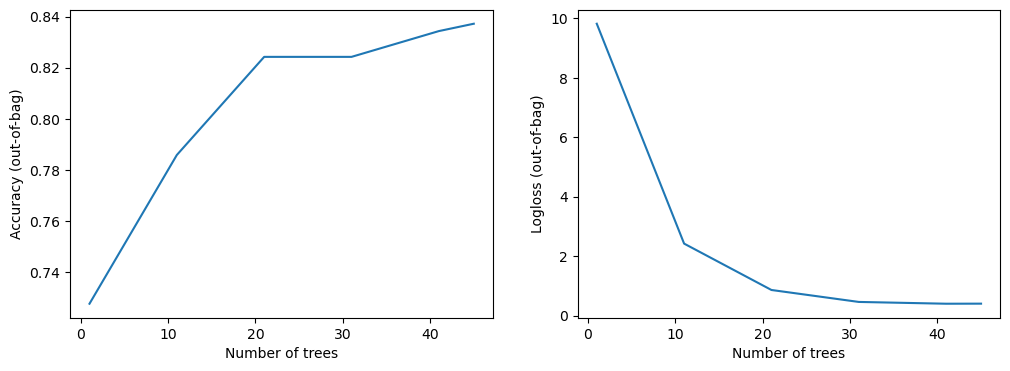

In [153]:
import matplotlib.pyplot as plt
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

We can also see some general stats on the OOB dataset:

In [154]:
inspector = model.make_inspector()
inspector.evaluation()

Evaluation(num_examples=694, accuracy=0.8371757925072046, loss=0.4003139183580102, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [155]:
evaluation = model.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 202ms/step - loss: 0.0000e+00 - accuracy: 0.8547
loss: 0.0000
accuracy: 0.8547


# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [140]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [141]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("Shoe_name" (4; #5), 22.0),
 ("category" (4; #7), 10.0),
 ("Color_4" (4; #3), 5.0),
 ("Gender" (4; #4), 5.0),
 ("Color_2" (4; #1), 1.0),
 ("inStock" (1; #8), 1.0),
 ("isBestSeller" (1; #9), 1.0)]

In [30]:
inspector.variable_importances()["SUM_SCORE"]

[("Shoe_name" (4; #5), 5089.565502723679),
 ("category" (4; #7), 2087.2199962055893),
 ("Color_2" (4; #1), 1181.0688782501966),
 ("Color_3" (4; #2), 819.8270762376487),
 ("Color_1" (4; #0), 800.4313934603706),
 ("Gender" (4; #4), 765.7020364366472),
 ("Color_4" (4; #3), 513.6018853425048),
 ("inStock" (1; #8), 341.35274451598525),
 ("isBestSeller" (1; #9), 146.63550890795887),
 ("isMemberExclusive" (1; #10), 95.22126549622044),
 ("numColors" (1; #13), 60.019588727504015),
 ("isNew" (1; #11), 55.68249329645187),
 ("isSustainable" (1; #12), 24.409119479358196)]

In [31]:
inspector.variable_importances()

{'INV_MEAN_MIN_DEPTH': [("Shoe_name" (4; #5), 0.40458949677072725),
  ("category" (4; #7), 0.3147261465893181),
  ("Color_1" (4; #0), 0.16914285293299783),
  ("Color_2" (4; #1), 0.16806807739073726),
  ("Gender" (4; #4), 0.16389650377683948),
  ("Color_4" (4; #3), 0.1447159348971905),
  ("Color_3" (4; #2), 0.13929717064167468),
  ("inStock" (1; #8), 0.12161705236612848),
  ("isBestSeller" (1; #9), 0.11639281080721038),
  ("isMemberExclusive" (1; #10), 0.1092444281585354),
  ("isSustainable" (1; #12), 0.10871091626099454),
  ("isNew" (1; #11), 0.1085145441665593),
  ("numColors" (1; #13), 0.10768766796838215)],
 'NUM_AS_ROOT': [("Shoe_name" (4; #5), 15.0),
  ("category" (4; #7), 9.0),
  ("Gender" (4; #4), 3.0),
  ("Color_4" (4; #3), 2.0),
  ("Color_2" (4; #1), 1.0)],
 'NUM_NODES': [("Shoe_name" (4; #5), 258.0),
  ("Color_2" (4; #1), 227.0),
  ("category" (4; #7), 201.0),
  ("Color_3" (4; #2), 176.0),
  ("Color_1" (4; #0), 162.0),
  ("Gender" (4; #4), 126.0),
  ("Color_4" (4; #3), 108.0)